In [3]:
# Local Imports
#from ctrainingdataset import CTrainingDataSet, CreateDataSetFromImageFiles, ReadTrainingSets, ReadLabelDict
import signplot
import p3signs

%load_ext autoreload
%autoreload 1
#%aimport ctrainingdataset
%aimport signplot
%aimport p3signs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
jnk = display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
#====================== GLOBALS =====================
g_Args = p3signs.GetgArgs()
g_Args.numEpochs = 22
g_Args.batchSize = 128
g_Args.trainRate = 0.001
g_Args.doConvertGray = True

signplot.g_doShowPlots = True


In [5]:
%autoreload 1
#====================== Main() =====================
def Main(gArgs):
    
    #################### Sort-of global object containers
    tfObjs = type("TensorFlowObjectsContainer", (object,), {})
    tfObjs.tph = None  # Assigned in DefineTFPlaceHolders()

    
    #################### READ DATASETS
    dictIDToLabel = p3signs.ReadLabelDict(gArgs.signLabelsCSVFileIn)
    dsTrainRaw, dsValidRaw, dsTestRaw = p3signs.ReadTrainingSets(gArgs.trainingFileIn, gArgs.validationFileIn, gArgs.testingFileIn, dictIDToLabel, truncatedTrainingSetSize = gArgs.truncatedTrainingSetSize)
    signplot.LabeledSampleImages(dsTrainRaw)
    signplot.NumTrainingImagesHistogram(dsTrainRaw, dsValidRaw, dsTestRaw)
    

    
    #################### CREATE AUGMENTS
    if (gArgs.doComputeAugments):
        listDSInSegregated, listDSOutAugmentedSegregated, dsOutAugments, dsTrainComplete = p3signs.CreateAugmentedDataSets(dsTrainRaw)
        signplot.PlotListOfDataSets(listDSOutAugmentedSegregated, "augments")
        
        if(gArgs.doSaveTrainCompleteFile):
            print("Saving augment complete file {}".format(gArgs.trainingCompleteFile))
            dsTrainComplete.WritePickleFile(gArgs.trainingCompleteFile)
    else:
        print("Loading augment complete file {}".format(gArgs.trainingCompleteFile))
        dsTrainComplete = p3signs.CTrainingDataSet(name="TrainComplete", pickleFileNameIn = gArgs.trainingCompleteFile, dictIDToLabel = dictIDToLabel)

    signplot.NumTrainingImagesHistogram(dsTrainComplete, dsValidRaw, dsTestRaw)

    
    
    #################### NORM, TRAINING & EVAL
    dsTrainNormComplete, dsValidNorm, dsTestNorm = p3signs.NormalizeDataSets([dsTrainComplete, dsValidRaw, dsTestRaw], gArgs.doConvertGray)
    tfObjs.tph = p3signs.DefineTFPlaceHolders(dsTrainRaw.GetDSNumLabels(), gArgs)
    p3signs.TrainingPipeline(dsTrainNormComplete, dsValidNorm, tfObjs, gArgs)
    p3signs.EvalDataSets([dsTrainNormComplete, dsValidNorm, dsTestNorm], tfObjs, gArgs)
    
    

    #################### EXTRA DATASET
    dsExtraRaw = p3signs.CreateDataSetFromImageFiles(gArgs.finalTestFilesDirIn, dictIDToLabel)
    signplot.LabeledSampleImages(dsExtraRaw)

    dsExtraNorm, = p3signs.NormalizeDataSets([dsExtraRaw], gArgs.doConvertGray)
    p3signs.EvalDataSets([dsExtraNorm], tfObjs, gArgs)
    topk = p3signs.CalcSoftmaxTopK(dsExtraNorm, tfObjs, gArgs)
    signplot.PredictionComparison(dsExtraRaw, dsTrainRaw, topk)




Reading Training sets...
Raw training set size (train, validation, test) =(34799, 4410, 12630)
Image data shape = (32, 32, 3)
Number of classes = 43


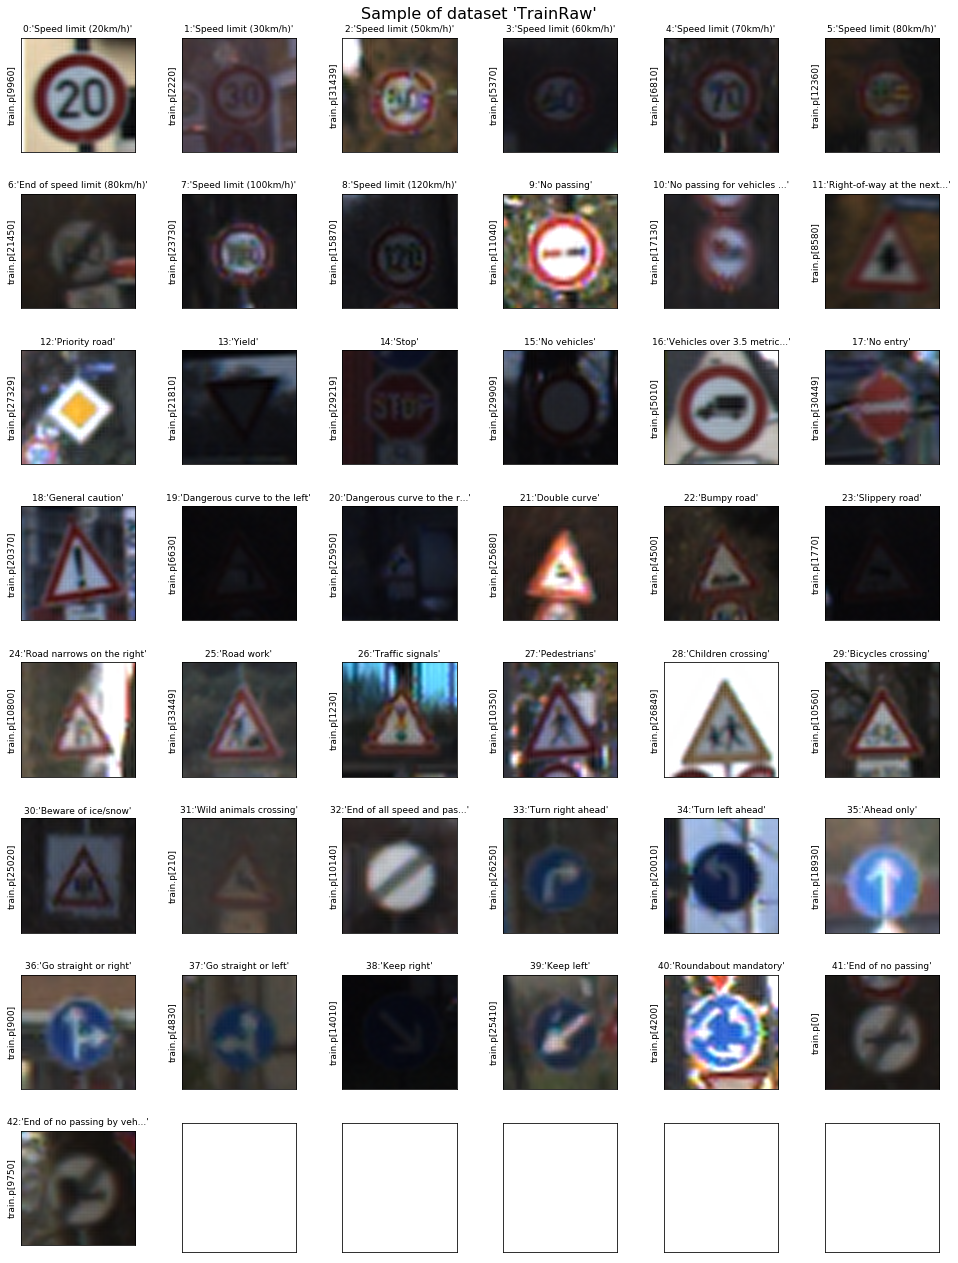

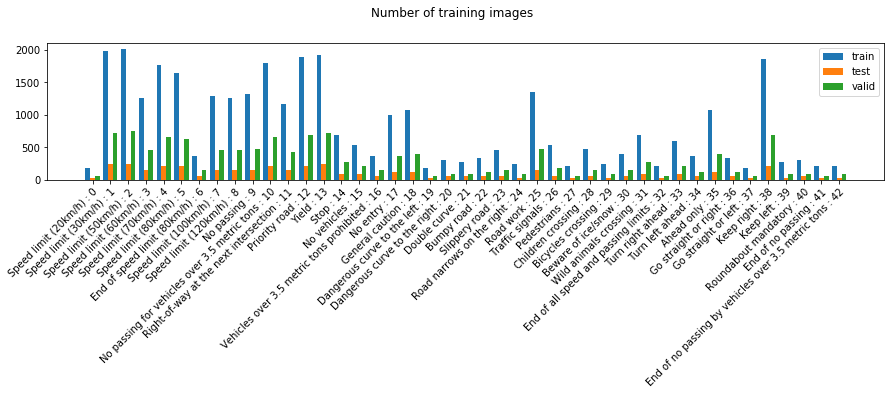

Loading augment complete file ./Assets/training/trainComplete.p

Normalizing...convertGrayScale ==True. 29.9 seconds

Training for 22 Epochs...
Epoch 01... Validation Accuracy = 0.803
Epoch 02... Validation Accuracy = 0.884
Epoch 03... Validation Accuracy = 0.913
Epoch 04... Validation Accuracy = 0.924
Epoch 05... Validation Accuracy = 0.937
Epoch 06... Validation Accuracy = 0.943
Epoch 07... Validation Accuracy = 0.954
Epoch 08... Validation Accuracy = 0.956
Epoch 09... Validation Accuracy = 0.959
Epoch 10... Validation Accuracy = 0.958
Epoch 11... Validation Accuracy = 0.960
Epoch 12... Validation Accuracy = 0.968
Epoch 13... Validation Accuracy = 0.971
Epoch 14... Validation Accuracy = 0.963
Epoch 15... Validation Accuracy = 0.959
Epoch 16... Validation Accuracy = 0.966
Epoch 17... Validation Accuracy = 0.964
Epoch 18... Validation Accuracy = 0.972
Epoch 19... Validation Accuracy = 0.968
Epoch 20... Validation Accuracy = 0.969
Epoch 21... Validation Accuracy = 0.970
Epoch 22... Vali

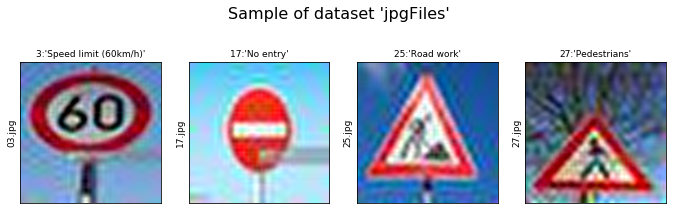


Normalizing...convertGrayScale ==True. 0.5 seconds

Eval Model on datasets
Eval DataSet(jpgFilesNorm) Accuracy = 0.750

CalcSoftmaxTopK(jpgFilesNorm)
Image[0]=(    03.jpg) type 03: 'Speed limit (60km/h)'.  Top 3 Match IDs[40 18 37] => probabilites: [ 0.90215027  0.03334016  0.02054866]
Image[1]=(    25.jpg) type 25: 'Road work'.  Top 3 Match IDs[25 24 22] => probabilites: [  9.99945641e-01   3.21979460e-05   7.10332824e-06]
Image[2]=(    17.jpg) type 17: 'No entry'.  Top 3 Match IDs[17 14 39] => probabilites: [ 0.97926223  0.00979837  0.00887326]
Image[3]=(    27.jpg) type 27: 'Pedestrians'.  Top 3 Match IDs[27 18 26] => probabilites: [ 0.94304043  0.0454246   0.00659317]


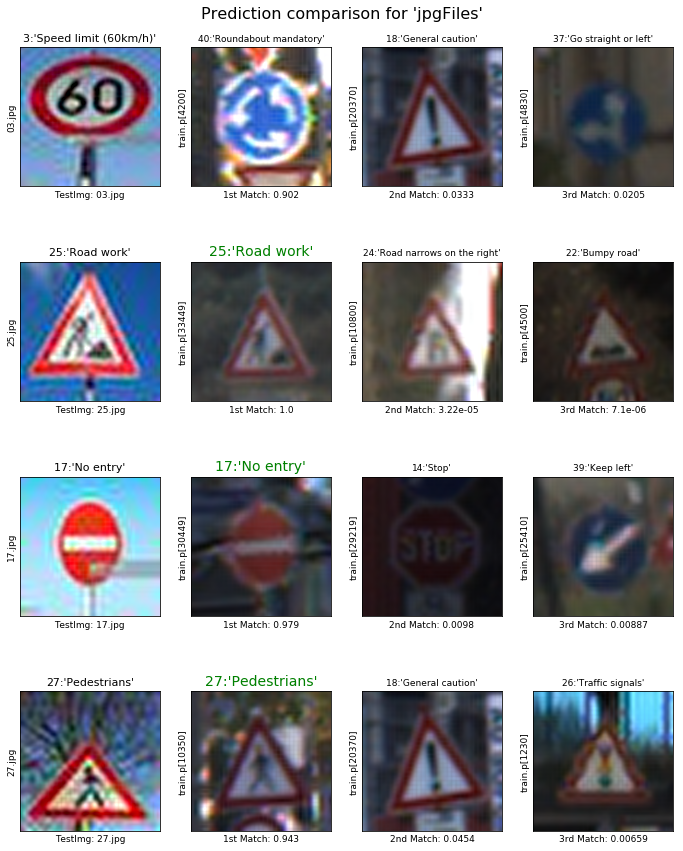

In [8]:
%autoreload 1

#====================== Main Invocation =====================
Main(g_Args)